# ***Image Colorization with U-Net and GAN***

## *1.1 -  Introduction to colorization problem - RGB v/s LAB colorspace*

An image is a (Height, Width, Color) array with the last axis containing the color data for our image. 

**These images represent color channels in RGB color space**

![rgb image](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/rgb.jpg?raw=1)


In a L\*a\*b colorspace, **L encodes the Lightness of each pixel.**
It appears to be a grayscale image, where the shades of gray denote the color intensity.

 **The \*a and \*b channels encode how much green-red and yellow-blue each pixel is, respectively**. 

![lab image](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/lab.jpg?raw=1)

***Computer Vision projects use LAB color space instead of RGB to train the models.***

*   We **give the L channel** to the model (the grayscale image).
*   It **predicts the other two channels**   (\*a, \*b)  
*   After its prediction, we **concatenate (combine) all the channels** and we **get our colorful image.**
 


But  **if you use RGB**, you have to first convert your image to grayscale, feed the grayscale image to the model and hope it will **predict 3 numbers for you which is a way more difficult and unstable task** due to the many more possible combinations of 3 numbers compared to two numbers.

## *1.2 - The strategy we are going to use*

**Reference Paper for Colorization :**

 [_**Image-to-Image Translation with Conditional Adversarial Networks**_](https://arxiv.org/abs/1611.07004) paper, which is also known by the name ***'pix2pix'***, proposed a general solution to many image-to-image tasks in deep learning, one of which was colorization. 



*We will also introduce a whole new generator model and some tweaks in the strategy of training which significantly helps reduce the size of needed dataset while getting successful results.*


---


### *Concept*

***CONDITIONAL GAN:***

*   In a normal GAN, there is no control over modes of the data to be generated.
* *The Conditional GAN* changes that **by adding the 'label' as an additional parameter to the Generator and  try to generate the corresponding data point better.**. We also **add labels to the Discriminator input to distinguish real images better.**







We have  **a generator and a discriminator model**  which learn to solve a problem together. 


1. *The generator model will take a grayscale image* and  *produces a 2-channel image, a channel for *a and another for *b.*

2. *The discriminator, will take these two output channels, concatenate them with the Input Grayscale image and decide whether this new 3-channel image is fake or real.*





### *Loss function we optimize*

In this approach **two losses are used**:

 1. **L1 loss**, which makes it a regression task,
 
 2. An **adversarial **(GAN) loss****, which helps to solve the problem in an unsupervised manner.

***L1 loss function helps to produce realistic, good-looking colorful images, but to further help the models we need to introduce some supervision in our task.***

- If we use L1 loss alone, **the model still learns to colorize the images, but it will be conservative and most of the time uses colors like "gray" or "brown" because when it doubts which color is the best**, it takes the average and uses these colors to reduce the L1 loss as much as possible. 

- Also, the L1 Loss is preferred over L2 loss (or mean squared error) because it **reduces the effect of producing gray-ish images.** 

## *1.3  Implementing the paper - Our Baseline*

Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.1- Loading Image Paths

The paper uses the whole **ImageNet dataset** with 1.3 million images but here we're using only **8,000 images from COCO dataset.**

In [2]:
# importing OS, FilePath, and Image Pre-processing Libraries
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

# Libraries for PyTorch Neural Network Functionalities
import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

### Preparing Colab for running the code

**Fastai** : simplifies training fast and accurate neural nets using modern best practices

In [3]:
# fastai : popular open-source library used for practicing machine learning and deep learning
!pip install fastai==2.4

     |████████████████████████████████| 187 kB 8.3 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 831.4 MB 6.4 kB/s 
     |████████████████████████████████| 23.2 MB 44.3 MB/s 
     |████████████████████████████████| 23.3 MB 1.2 MB/s 
     |████████████████████████████████| 23.3 MB 1.3 MB/s 
     |████████████████████████████████| 22.1 MB 1.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
ERROR: pip's dependency resolver does not currently take into account all the 

The following will download about 20,000 images from COCO dataset. **We are going to use only 8000 of them** for training. 

In [4]:
from fastai.data.external import untar_data, URLs
#It downloads and extracts url, by default to subdirectories of ~/.fastai, and returns the path to the extracted data.
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"
use_colab = True

In [5]:
if use_colab == True:
    path = coco_path


# Grabbing all the image file names
paths = glob.glob(path + "/*.jpg") 

np.random.seed(123)

# choosing 10,000 images randomly, split of data is 80 : 20
paths_subset = np.random.choice(paths, 10_000, replace=False)
rand_idxs = np.random.permutation(10_000)

# choosing the first 8000 as training set
train_idxs = rand_idxs[:8000] 
val_idxs = rand_idxs[8000:] 

# choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]

print(len(train_paths), len(val_paths))

8000 2000


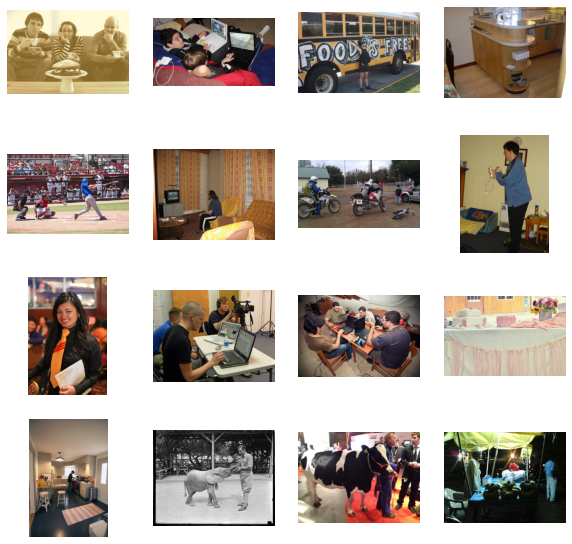

In [6]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

### *1.4  - Making Datasets and DataLoaders*

Some initial Data Augmentation :-

We're **resizing the images and flipping horizontally** (flipping only if it is training set).

We then **read grayscale channel and the color channels as the inputs and targets** for the models respectively. We're also making the **data loaders**.

In [7]:
SIZE = 256

class ColorizationDataset(Dataset):

    def __init__(self, paths, split='train'):

        # Data Augmentation ie. Resizing, Horizontal Flipping only for train set

        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation.
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    

    def __getitem__(self, idx):
        
        # When an input image is provided, this function extracts the image from its path, makes transformations
        # & converts it into an array. This is followed by conversion from RGB to LAB color space and
        # normalisation of pixel values
        
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32")
        
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        # returns the number of image files
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs):
   
   # A handy function to make our dataloaders - similar to batches of data in Tensorflow
   # For computational efficiency
   
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [8]:
# making training and test / validation dataloaders

train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

# returns shape of 'L' and 'ab' channels
data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  


torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
500 125


## *1.5 Architecture of the GAN (as proposed by the paper)*

### 1.5.1 Generator proposed by the paper

This code implements a **U-Net as the generator of the GAN prosposed**. 

The important thing to understand is that ***it makes the U-Net from the middle part of it (down in the U shape) and adds down-sampling and up-sampling modules to the left and right of that middle module (respectively) at every iteration until it reaches the input module and output module.*** 

![unet](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/unet.png?raw=1)

We're going 8 layers down, so if we start with a 256*256 image.

In the middle of the U-Net we will get a 1 by 1 (256 / 2⁸) image and then it gets up-sampled to produce a  256 by 256 image (with two channels). 

In [9]:
class UnetBlock(nn.Module):
    # Function for creating a UNetBlock (as described above)

    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
      
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf

        # Downsampling - blocks of Conv2D, LeakyReLU and BatchNorm2D
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)

        #Upsampling :- ReLU and BatchNorm2D
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        # Notice that the first and last blocks do not use normalization 
        # the last block has no activation function (it is embedded in the loss function we will use).
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
            # Sequential Model
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

### 1.5.2 - Discriminator

**Architecture of our discriminator:-**

We're implementing a ***Patch Discriminator by stacking blocks of Conv-BatchNorm-LeakyReLU to decide whether the input image is fake or real***. 

*The first and last blocks do not use normalization and the last block has no activation function  (it is embedded in the loss function).*

In [10]:
class PatchDiscriminator(nn.Module):

# Stacking blocks of Conv-BatchNorm-LeakyReLU to decide whether the input image is fake or real.

    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)]
        #'If' statement is taking care of not using
        # stride of 2 for the last block in this loop

        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] 
        # We're making sure to not use normalization or
        # activation for the last layer of the model.

        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): 

        # When needing to make some repeatitive blocks of layers,
        # it's always helpful to make a separate method for that purpose.

        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]         
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

Blocks of Discriminator:

In [11]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

And its output shape:

In [12]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) 

# batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

We've used a ***Patch Discriminator*** here. 

 ->  In a vanilla discriminator, the model outputs one number (a scaler), denoting how much the model thinks the input (the whole image) is real or fake. 

 -> **In a patch discriminator, the model outputs *one number for every patch of the input image* (say, 70 by 70 pixels)  & for each of them decides whether it is fake or not separately**. 

This seems reasonable for the task of colorization because the ***local changes that the model needs to make are really important, such details cannot be handled by a Vanilla Discriminator*** 


### *1.5.3 - GAN Loss*

Class to **calculate the GAN loss of our final model.** 

- In the __init__ function, we **decide which kind of loss** we're going to use (vanilla in our project) and **register some constant tensors as the "real" and "fake" labels.** 
- We then call this module, which makes an appropriate tensor full of zeros or ones, & computes the loss.

In [13]:
class GANLoss(nn.Module):
    # GANLoss as described above.
    
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

## *1.6 -  Model Initialization*

Here is our *logic to initialize our models.* 

We are going to **initialize the weights of our model** with ***mean of 0.0 & standard deviation of 0.02*** (the proposed hyperparameters)

In [14]:
def init_weights(net, init='norm', gain=0.02):

    # logic to initialise the weights of our model
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

## *1.7 - Compiling everything together!*

***This class brings together all the previous parts & implements a few methods to take care of training our complete model.***  

 1. In the __init__, we **define our generator and discriminator** using the previous functions and classes we defined & we also **initialize them with init_model function.** 
 
 2. We  then **define our two *loss functions & optimizers*** of the generator and discriminator. 

 3. The whole work is performed in **optimize method** of this class. 

 



*DISCRIMINATOR:*

  a.  *First and only once per iteration (batch of training set), we **call the module's forward method** & store the outputs in fake_color variable of the class* 
  
  b. We first **train the discriminator by using backward_D method** in which we **feed the fake images produced by generator to the discriminator** (make sure to detach them from the generator's graph so that they act as a constant to the discriminator, like normal images) and **label them as fake.** 
 
  c. We **feed a batch of real images from training set to the discriminator and label them as real.** 
 
  d. We **add up the two losses for fake and real** and **take the average** and then **call the backward on the final loss**. 

*GENERATOR:*

  a. **In backward_G method, we feed the discriminator the fake image & try to fool it by assigning real labels to them and calculating the adversarial loss.**

  b. We'll use **L1 loss** as well, **compute the distance between the predicted two channels and the target two channels** and **multiply this loss by a coefficient** (which is 100 in our case) to balance the two losses and then add this loss to the adversarial loss. Then we call the backward method of the loss.

In [15]:
class MainModel(nn.Module):
  
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

## *1.8 -  Utility functions*

These are simply **some utility functions to log the losses of our network, & visualize the results during training.** 

In [16]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    #create loss meters
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    # update losses of the model
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images, converts from lab to rgb
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
  # visualise and log the results obtained
  
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

## *1.7 - Training function*

In [17]:
assert false

NameError: ignored

In [ ]:
def train_model(model, train_dl, epochs, display_every=200):
    data = next(iter(val_dl)) 
    # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # This is a function returning a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")

                log_results(loss_meter_dict) # This function prints out the losses
                visualize(model, data, save=False) # This function displays the model's outputs

#model = MainModel()
#train_model(model, train_dl, 100)

*The results of the baseline model post 100 epochs training:*

![baseline](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/baseline.png?raw=1)

***Limitations of this approach***:

- Although this baseline model has some basic understanding of some of the most common objects in images like sky, trees, … its output is far from appealing and it cannot decide on the color of rare objects. 

- It also displays some color spillovers and circle-shaped mass of color (center of first image of second row) which isn't appreciated. We cannot achieve successful results using this model.

**We, therefore, change our strategy.**

## *2 - A new strategy - the final model*

We've **pretrained the generator separately** in a supervised and deterministic manner.

This is done to **avoid the problem of "the blind leading the blind"** in the GAN game.

i.e., where neither generator nor discriminator knows anything about the task at the beginning of training. 

We have used pretraining in two stages: 

 - **The backbone of the generator (the down-sampling path) is a pretrained model for classification (pretrained ResNet 18)**

 - The whole generator will be pretrained on the task of colorization with **L1 loss.**



***We're going to use a pretrained ResNet18 as the backbone of our U-Net and to accomplish the second stage of pretraining, we are going to train the U-Net on our training set with only L1 Loss.***

We will then move to the combined adversarial and L1 loss, as we did in the previous section.

*Credits: Moein Shariatnia (Medium Writer)*

## *2.1- Using a new generator*

We'll use **fastai** library's Dynamic U-Net module ***to easily build a UNet with a ResNet backbone***. 

In [18]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

 ***create_body function*** :- loads the pretrained weights of the ResNet18 architecture and cuts the model to remove the last two layers (GlobalAveragePooling and a Linear layer for the ImageNet classification task).
 
DynamicUnet uses this backbone **to build a U-Net** with the **needed output channels (2 in our case)** and with an input size of 256.

In [19]:
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

##*2.2 -  Pretraining the generator for colorization task*

In [ ]:
assert false 

In [ ]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            loss_meter.update(loss.item(), L.size(0))
            
        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

net_G = build_res_unet(n_input=1, n_output=2, size=256)
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()        
#pretrain_generator(net_G, train_dl, opt, criterion, 20)
#torch.save(net_G.state_dict(), "res18-unet.pt")

We **pretrain the generator for 20 epochs and then we save its weights.** 

We will **use this model as the generator for our GAN** and train the whole network as before:

In [ ]:
#torch.save(net_G.state_dict(), "res18-unet.pt")

## *2.3 - Putting everything together.*

Our model checkpoints:
- 

- final_model_weights.pt

In [20]:
 !gdown --id 1lR6DcS4m5InSbZ5y59zkH2mHt_4RQ2KV

Downloading...
From: https://drive.google.com/uc?id=1lR6DcS4m5InSbZ5y59zkH2mHt_4RQ2KV
To: /content/final_model_weights.pt
100% 136M/136M [00:00<00:00, 137MB/s]


- res18-unet.pt

In [21]:
!gdown --id 11_NgV0jctLlJbPm0zvRwUzIwd0FHRyRv

Downloading...
From: https://drive.google.com/uc?id=11_NgV0jctLlJbPm0zvRwUzIwd0FHRyRv
To: /content/res18-unet.pt
100% 125M/125M [00:00<00:00, 203MB/s]


***load_state_dict*** : Loading the saved model checkpoints

In [22]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18-unet.pt", map_location=device))

model = MainModel(net_G=net_G)
model.load_state_dict(torch.load("final_model_weights.pt", map_location=device))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

model initialized with norm initialization


<All keys matched successfully>

## *3 - Model Inference*

In [23]:
import PIL
from PIL import Image
import torch
from matplotlib import pyplot as plt
from torchvision import transforms
import cv2
import IPython
from IPython.display import Image


In [24]:
def colorize_image(path):

  original_img = PIL.Image.open(path)

  # transformations
  original_img = original_img.resize((256, 256))
  img = transforms.ToTensor()(original_img)[:1] * 2. - 1.
  model.eval()
  with torch.no_grad():
     preds = model.net_G(img.unsqueeze(0).to(device))
  colorized = lab_to_rgb(img.unsqueeze(0), preds.cpu())[0]

  # converting np.ndarray into PIL Image
  colorized = colorized* 255
  colorized = colorized.astype(np.uint8)
  colorized = PIL.Image.fromarray(colorized)

  # display images
  display(original_img)
  print('OUTPUT:─') 
  display(colorized)


img_1.jpg


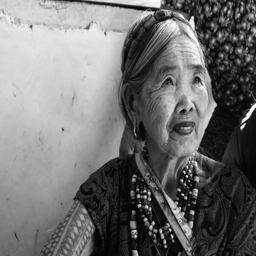

OUTPUT:─


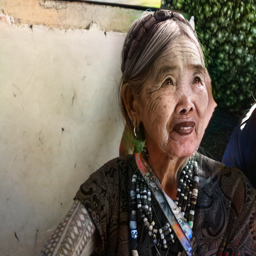

img_10.jfif


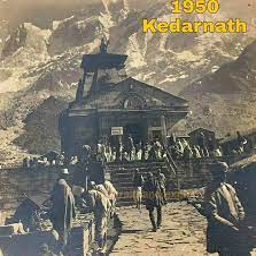

OUTPUT:─


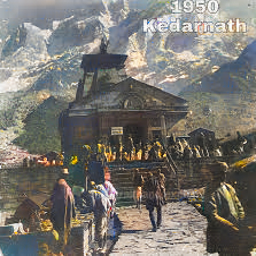

img_2.jfif


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


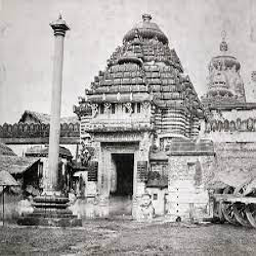

OUTPUT:─


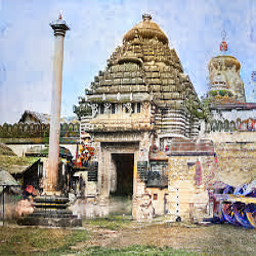

img_3.jfif


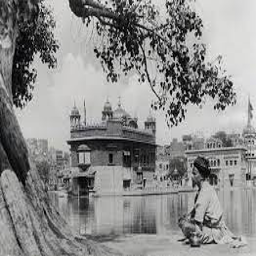

OUTPUT:─


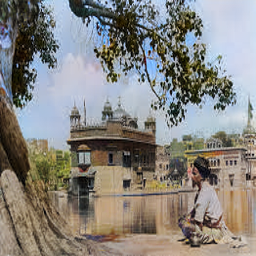

img_4.jfif


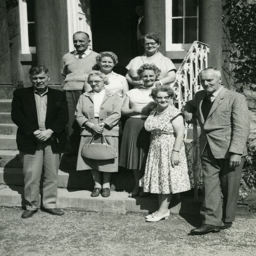

OUTPUT:─


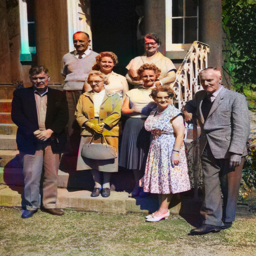

img_5.jfif


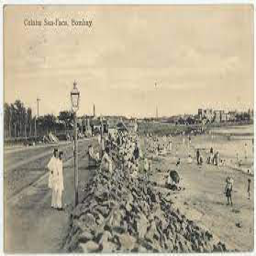

OUTPUT:─


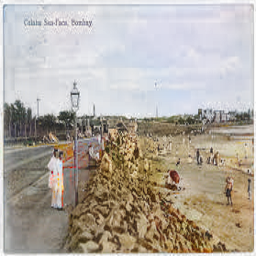

img_5.png


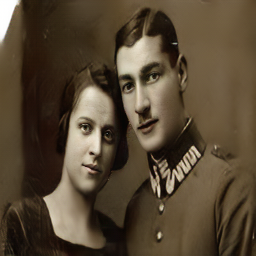

OUTPUT:─


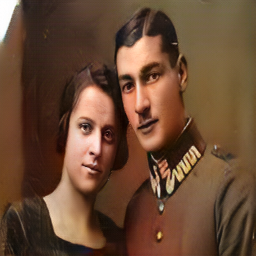

img_6.png


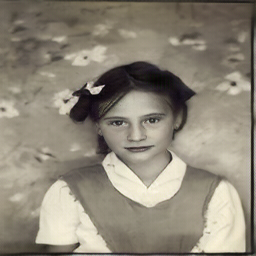

OUTPUT:─


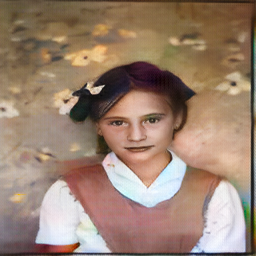

img_7.png


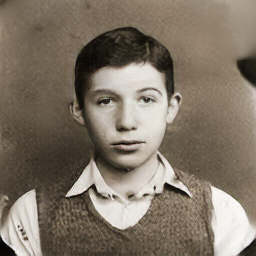

OUTPUT:─


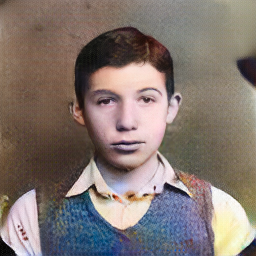

img_8.jpg


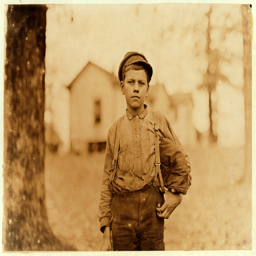

OUTPUT:─


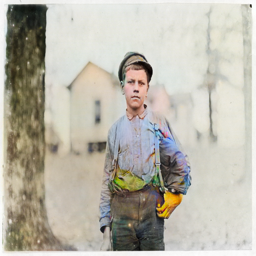

img_9.jfif


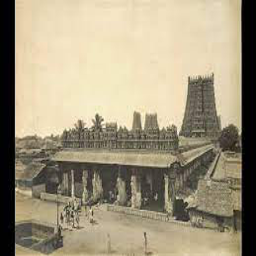

OUTPUT:─


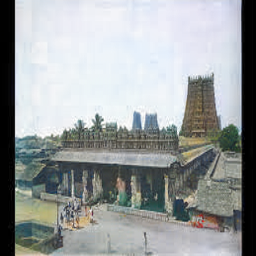

In [25]:
import os
import shutil

input_path = '/content/drive/MyDrive/inference_images'

filenames = os.listdir('/content/drive/MyDrive/inference_images')
filenames.sort()

for filename in filenames:
    individual_path = os.path.join(input_path, filename)
    print(filename)
    colorize_image(individual_path)
    

We can see that how pretraining the generator significantly helped the model and improved the results.

I want to thank the authors of this wonderful paper for their awesome work, [the great GitHub repository of this paper](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) from which we've referred some of the code (with modification and simplification). 

*We would also like to give credits to the Medium Article "Image colorization using U-Net and GAN" by Moein Shariatnia for giving amazing insights on this topic.*
